In [1]:
import numpy as np
from matplotlib.pylab import *
from scipy.optimize import minimize

In [2]:
data = np.genfromtxt('VCC.txt',dtype=None, skip_header=2)
# data = np.loadtxt('VCC.txt', dtype=None, skiprows=2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [3]:
idx = [0,1,2,3,4,6]
v = data['f19'][idx]
sigmav= data['f21'][idx]

In [4]:
rcParams.update({'font.size': 21})

        Use astropy.visualization.hist instead. [warnings]


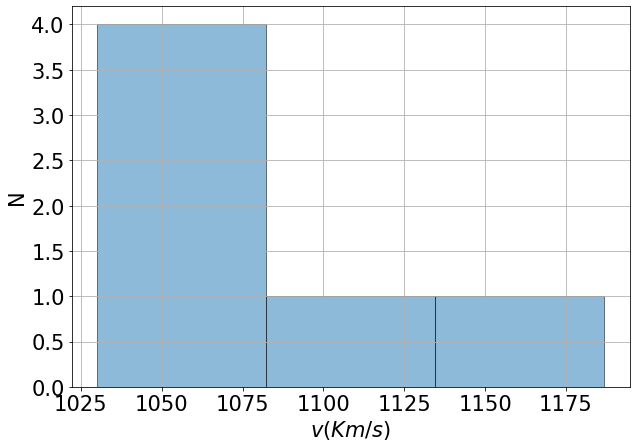

In [5]:
from astroML.plotting import hist
figure(figsize=(10,7))
hist(v, ec='k', alpha =0.5, bins ='freedman')
xlabel('$v (Km/s)$')
ylabel('N')
grid('on')
show()

In [6]:
from scipy import stats
ndist= stats.norm(np.mean(v),np.std(v))
N_data = len(v)
mock_v= ndist.rvs(N_data)
v_mod= np.linspace(np.min(v)-100,np.max(v)+100,100)
N_mod= ndist.pdf(v_mod)
print(np.std(mock_v))
print(np.std(v))

41.86841290401575
37.281213618777066


        Use astropy.visualization.hist instead. [warnings]
        Use astropy.visualization.hist instead. [warnings]


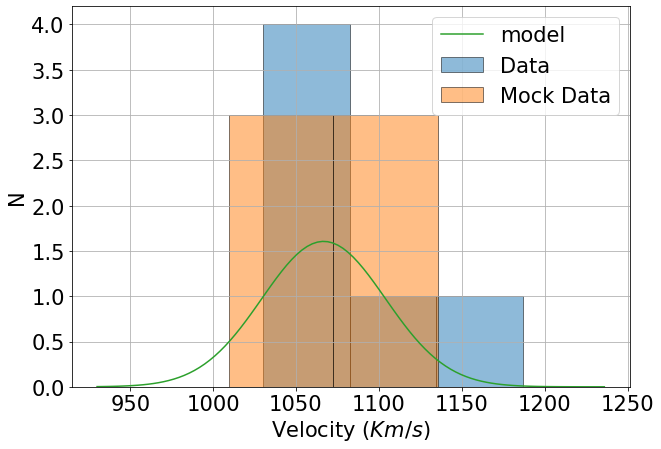

In [7]:
figure(figsize=(10,7))
hist(v, ec='k', alpha =0.5, bins ='freedman', label = 'Data')
hist(mock_v, ec='k', alpha =0.5, bins ='freedman', label = 'Mock Data')
plt.plot(v_mod,N_mod*N_data*25,'-',label='model')

xlabel('Velocity $(Km/s)$')
ylabel('N')
xticks()
yticks()
legend()
grid('on')
show()

In [8]:
# Calculating the chi^2 value for each mean value above
Nsigma, Nmean = 50, 50
mean_sample = np.linspace(950.0,1200.0,Nmean)
sigma_sample = np.linspace(1.0,50.0,Nsigma)
chi2 = np.zeros((Nsigma,Nmean))
for i in range(Nsigma) :
    for j in range(Nmean) :
        sig_eff = np.sqrt(sigmav**2 + sigma_sample[i]**2)
        log_p = -np.log(sig_eff) -(v - mean_sample[j])**2/(2.0*sig_eff**2)
        chi2[i,j] = -2*np.sum(log_p)
        
ind = np.unravel_index(np.argmin(chi2, axis=None), chi2.shape)
print(ind)
chi2min = np.min(chi2)
print('Best sigma: ', sigma_sample[ind[0]])
print('Best mu:', mean_sample[ind[1]])

# import sys
# numpy.set_printoptions(threshold=sys.maxsize)

(33, 24)
Best sigma:  34.0
Best mu: 1072.4489795918366


In [9]:
intial_guess = [30.0,1000.0]
mu_sig=np.concatenate((mean_sample, sigma_sample), axis=0)
np.shape(mu_sig)
def f(mu_sig, sigmav):
    sigma_sample = mu_sig[0]
    mean_sample = mu_sig[1]
    sig_eff = np.sqrt(sigmav**2 + sigma_sample**2)
    log_p = -np.log(sig_eff) -(v - mean_sample)**2/(2.0*sig_eff**2)
    return -2*np.sum(log_p)

results= minimize(f, intial_guess, args=sigmav)
print(results)

      fun: 49.722182229358594
 hess_inv: array([[ 81.4153638 , -12.82747247],
       [-12.82747247, 128.04361264]])
      jac: array([1.90734863e-06, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 104
      nit: 23
     njev: 26
   status: 0
  success: True
        x: array([  33.62270805, 1071.25530371])


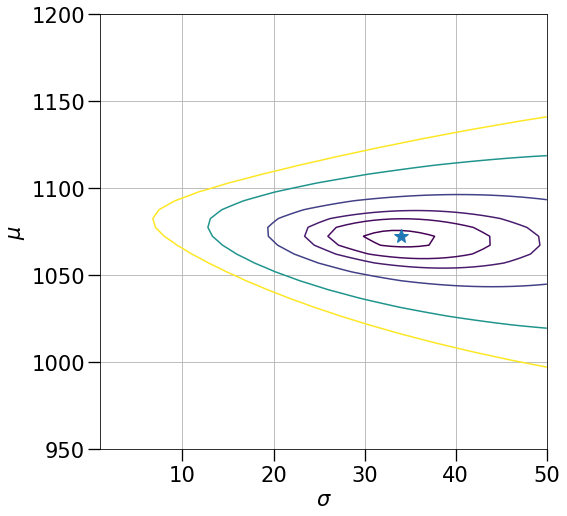

In [10]:
fig2 = plt.figure(figsize=(8,8))
DD, VV = np.meshgrid(sigma_sample,mean_sample)
plt.contour(DD,VV,chi2.T-chi2min,levels=[0.1,0.5,1.0,2.3,6.17,11.8])

plt.plot(sigma_sample[ind[0]],mean_sample[ind[1]],'*', markersize=15)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.tick_params('both', length=12, width=1.3, which='major')
grid('on')
show()

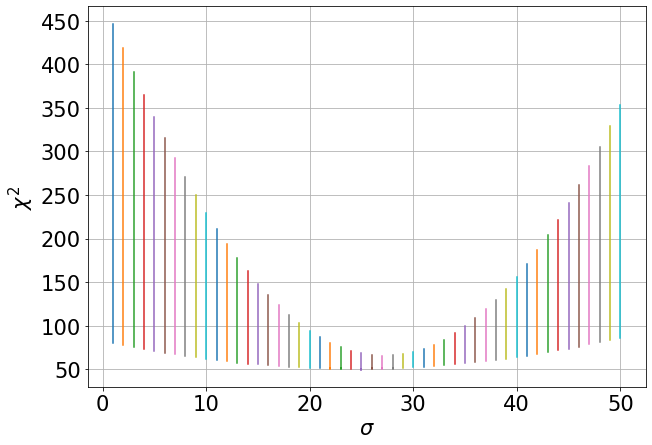

Looking at the graph above, the uncertainty in sigma is about +/- 5.0 Km/s


<Figure size 432x288 with 0 Axes>

In [11]:
figure(figsize=(10,7))
# for i in range(len(chi2)):
#     plot(sigma_sample, chi2[i,:], marker='o', alpha=0.5, ms=4)

plot(DD,chi2)
xlabel('$\sigma$')
ylabel('$\chi^2$')
# xlim([15, 40])
# ylim([47,55])
grid('on')
show()
tight_layout()
print('Looking at the graph above, the uncertainty in sigma is about +/- 5.0 Km/s')

Text(0.5, 0, '$\\chi^2$')

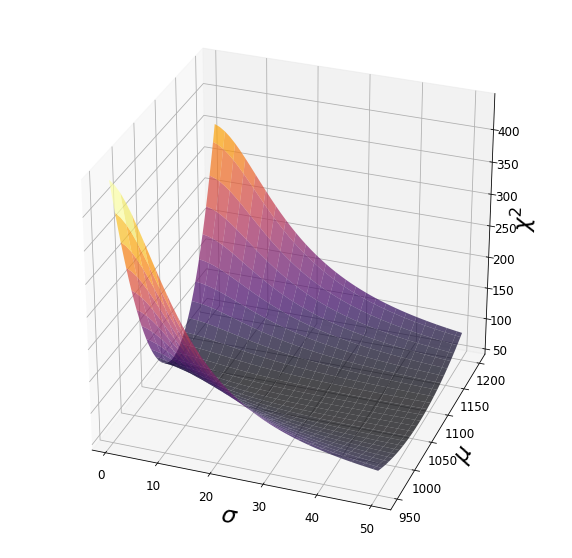

In [12]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 12})
fig3 = plt.figure(figsize=(10,10))
ax = fig3.gca(projection='3d')
ax.plot_surface(DD,VV,chi2.T, rstride=2, cstride=2, cmap='inferno', alpha=0.7) 
ax.view_init(30,-70) # tilt, rotate angles
plt.xlabel('$\sigma$', fontsize=23)
plt.ylabel('$\mu$', fontsize=23)
ax.set_zlabel('$\chi^2$',fontsize=23)

In [13]:
rcParams.update({'font.size': 21})

In [19]:
G = 6.67408e-11
Re = 3.3*3.086e+19 # kpc to m
M_star = 3.2e7 
M_star_sigma = 0.6e7

solar_mass= 1.989e+30 # solar mass in Kg
sigma = 35.0*1000 # get from the best sigma
sigma_unty = 3.0*1000 # get from the graph
Mdyn = (4*sigma**2*Re)/G/solar_mass
Md_unty = (4*Re*2*sigma*sigma_unty)/G/solar_mass
dm_fac = 1 - M_star/Mdyn

print('Dynamical mass: %.3f' % Mdyn)
print('Uncertainty: %.3f' %Md_unty)
print('Dark matter fraction: %.3f'% dm_fac )

Dynamical mass: 3759064264.429
Uncertainty: 644411016.759
Dark matter fraction: 0.991


        Use astropy.visualization.hist instead. [warnings]
        Use astropy.visualization.hist instead. [warnings]


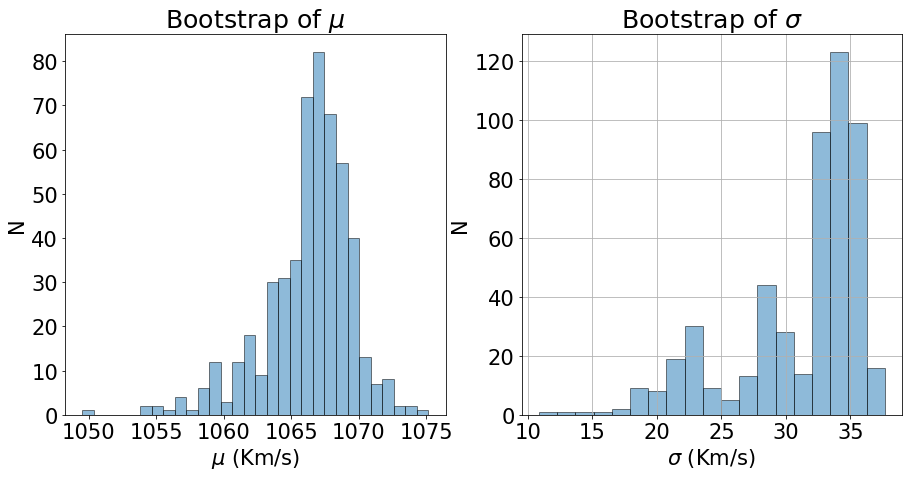

In [25]:
from astroML.resample import jackknife
from astroML.resample import bootstrap

N = len(v)
Nboot = N*np.log(N)**2 +500

mu_list = []
sigma_list = []
dm_list = []

for i in range(int(Nboot)):
    indices = np.random.randint(0,len(v), size = len(v))
    v_mock = v[indices]
    sigmav_mock = sigmav[indices]
    
    results= minimize(f, intial_guess, args=sigmav_mock)
    sigma = results.x[0]
    mu = results.x[1]
    sigma_list.append(sigma)
    mu_list.append(mu)
    
    Mdyn = (4*(sigma*1000)**2*Re)/G/solar_mass
#     Md_unty = (4*Re*2*sigma*sigma_unty)/G
    dm_fac = 1.0 - M_star/Mdyn
    dm_list.append(dm_fac)

figure(figsize=(15,7))
subplot(121)
hist(mu_list, ec='k', alpha =0.5, bins ='freedman')
title('Bootstrap of $\mu$')
xlabel('$\mu$ (Km/s)')
ylabel('N')

subplot(122)
hist(sigma_list, ec='k', alpha =0.5, bins ='freedman')
title('Bootstrap of $\sigma$')
xlabel('$\sigma$ (Km/s)')
ylabel('N')

grid('on')
show()



        Use astropy.visualization.hist instead. [warnings]


Text(0, 0.5, 'N')

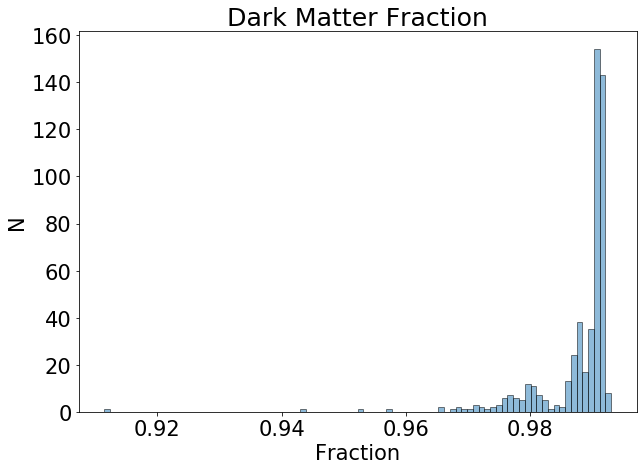

In [29]:
figure(figsize=[10,7])
hist(dm_list, ec='k', alpha =0.5, bins ='freedman')
title('Dark Matter Fraction')
xlabel('Fraction')
ylabel('N')

In [30]:
print('Bootstrap of sigma: %.3f +/- %.3f' %(np.mean(sigma_list), np.std(sigma_list)))
print('Bootstrap of mu: %.3f +/- %.3f' %(np.mean(mu_list), np.std(mu_list)))
print('Dark Matter Fraction: %.3f +/- %.3f' %(np.mean(dm_list), np.std(dm_list)))

Bootstrap of sigma: 31.184 +/- 4.936
Bootstrap of mu: 1066.279 +/- 3.241
Dark Matter Fraction: 0.988 +/- 0.007
